In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet

 99% 1.01G/1.03G [00:09<00:00, 137MB/s]
100% 1.03G/1.03G [00:09<00:00, 114MB/s]


In [5]:
!unzip -qq asl-alphabet.zip

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [7]:
tf.keras.utils.set_random_seed(1234)

In [8]:
imagePaths = "/content/asl_alphabet_train/asl_alphabet_train"
test_path="/content/asl_alphabet_test/asl_alphabet_test"

In [9]:
batch_size=32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


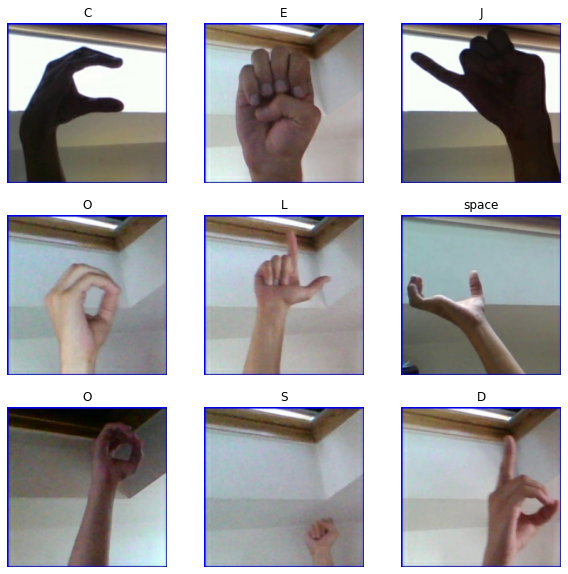

In [12]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation= Sequential([
                               
                               layers.RandomFlip("horizontal"),
                               layers.RandomRotation(0.5),
                               layers.RandomZoom(0.4),
])

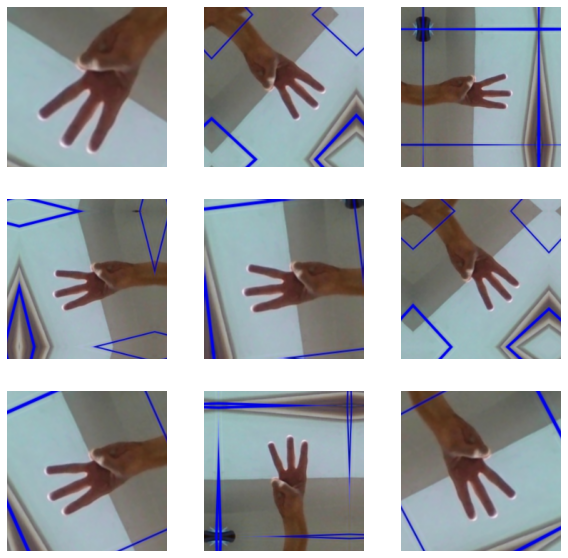

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
from tensorflow.keras import layers

In [ ]:
inputs= keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)


#Block: 1
x = Conv2D(256, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
residual = x
x = Conv2D(256, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2), padding = 'same')(x)
residual = Conv2D(256,1, strides=2)(residual)
x = layers.add([x, residual])
x = Dropout(0.3)(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


#Block: 2
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = Flatten(name='flatten')(x)
x = Dense(units=32, activation='relu')(x)
outputs = Dense(units=29, activation='softmax')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [16]:
def get_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [17]:
def get_checkpoint_best_only():
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [18]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stopping, checkpoint_best_only, tensorboard_callback]

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, callbacks=callbacks)

In [19]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
resnet_base.trainable = True

In [21]:
for layer in resnet_base.layers[: -4]:
  layer.trainable=False

In [26]:
inputs= keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = resnet_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(units=29, activation='softmax')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=10, callbacks=callbacks)

Epoch 1/10
2175/2175 [==============================] - ETA: 0s - loss: 13.2064 - accuracy: 0.6273
Epoch 1: val_accuracy improved from -inf to 0.81500, saving model to checkpoints_best_only


2175/2175 [==============================] - 450s 205ms/step - loss: 13.2064 - accuracy: 0.6273 - val_loss: 2.8636 - val_accuracy: 0.8150
Epoch 2/10
2175/2175 [==============================] - ETA: 0s - loss: 4.3727 - accuracy: 0.7572
Epoch 2: val_accuracy improved from 0.81500 to 0.83828, saving model to checkpoints_best_only


2175/2175 [==============================] - 427s 196ms/step - loss: 4.3727 - accuracy: 0.7572 - val_loss: 2.5902 - val_accuracy: 0.8383
Epoch 3/10
2175/2175 [==============================] - ETA: 0s - loss: 4.2575 - accuracy: 0.7795
Epoch 3: val_accuracy improved from 0.83828 to 0.86828, saving model to checkpoints_best_only


2175/2175 [==============================] - 427s 196ms/step - loss: 4.2575 - accuracy: 0.7795 - val_loss: 2.4505 - val_accuracy: 0.8683
Epoch 4/10
2175/2175 [==============================] - ETA: 0s - loss: 4.1379 - accuracy: 0.8097
Epoch 4: val_accuracy improved from 0.86828 to 0.90718, saving model to checkpoints_best_only


2175/2175 [==============================] - 427s 196ms/step - loss: 4.1379 - accuracy: 0.8097 - val_loss: 1.6650 - val_accuracy: 0.9072
Epoch 5/10
2175/2175 [==============================] - ETA: 0s - loss: 4.0159 - accuracy: 0.8341
Epoch 5: val_accuracy improved from 0.90718 to 0.91259, saving model to checkpoints_best_only


2175/2175 [==============================] - 430s 198ms/step - loss: 4.0159 - accuracy: 0.8341 - val_loss: 1.7769 - val_accuracy: 0.9126
Epoch 6/10
1583/2175 [====================>.........] - ETA: 1:33 - loss: 3.9089 - accuracy: 0.8484